# Clairvoyant Constructor

## Problem
At a large construction company, in order to submit more competitive bids for contracts, forecasting core construction material costs for up to six months in advance needs to be done. Data includes the pricing information (per unit, in dollars) for the company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years in csv format. 


## Approach
1). From the EDA results of the data, find out how the prices changed over the past ten years.

2). Forcast the prices from Jun to Nov in 2018 by using the SARIMA model.


## Results
Steel beams reached the lowest price in July. Rebar reached the lowest price in May, so it should be purchased as soon as possible to avoid further price increasing. Concrete reached the lowest price in August. Glass and plywood can be purchased at anytime.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from datetime import timedelta
from sklearn.metrics import mean_squared_error

# 1. Load data to dataframe

In [3]:
df = pd.read_excel("./construction_material_prices_2008_2018.xlsx", header=0, parse_dates=['date'], index_col='date')
df.head()

,price_steel,price_rebar,price_glass,price_concrete,price_plywood
date,,,,,
2007-01-01,NaN,NaN,NaN,NaN,NaN
2007-01-03,NaN,NaN,NaN,NaN,NaN
2007-01-04,NaN,NaN,NaN,NaN,NaN
2007-01-05,NaN,NaN,NaN,NaN,NaN
2007-01-08,NaN,NaN,NaN,NaN,NaN


In [4]:
df.describe()

,price_steel,price_rebar,price_glass,price_concrete,price_plywood
count,2309.000000,1649.000000,1472.000000,1447.000000,2673.000000
mean,12.611319,18.306339,29.997962,26.000636,12.775067
std,6.038862,8.587938,6.524622,7.314764,3.931698
min,3.062500,3.000000,16.000000,10.416667,5.000000
25%,8.500000,12.071429,25.000000,20.559028,10.125000
50%,10.500000,16.500000,29.000000,25.043478,12.125000
75%,14.833333,22.500000,35.000000,30.000000,14.333333
max,41.000000,55.000000,48.000000,50.000000,34.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2945 entries, 2007-01-01 to 2018-06-19
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_steel     2309 non-null   float64
 1   price_rebar     1649 non-null   float64
 2   price_glass     1472 non-null   float64
 3   price_concrete  1447 non-null   float64
 4   price_plywood   2673 non-null   float64
dtypes: float64(5)
memory usage: 138.0 KB


In [6]:
features = ['price_steel', 'price_rebar', 'price_glass', 'price_concrete', 'price_plywood']

# 2. EDA

In [7]:
def df_plot(df, features):
    i = 1
    nrows=len(features)
    plt.figure(figsize = (20,20))
    for col in features:
        plt.subplot(nrows, 1, i)
        plt.plot(df[col])
        plt.ylabel(col,fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        i += 1
    plt.show()

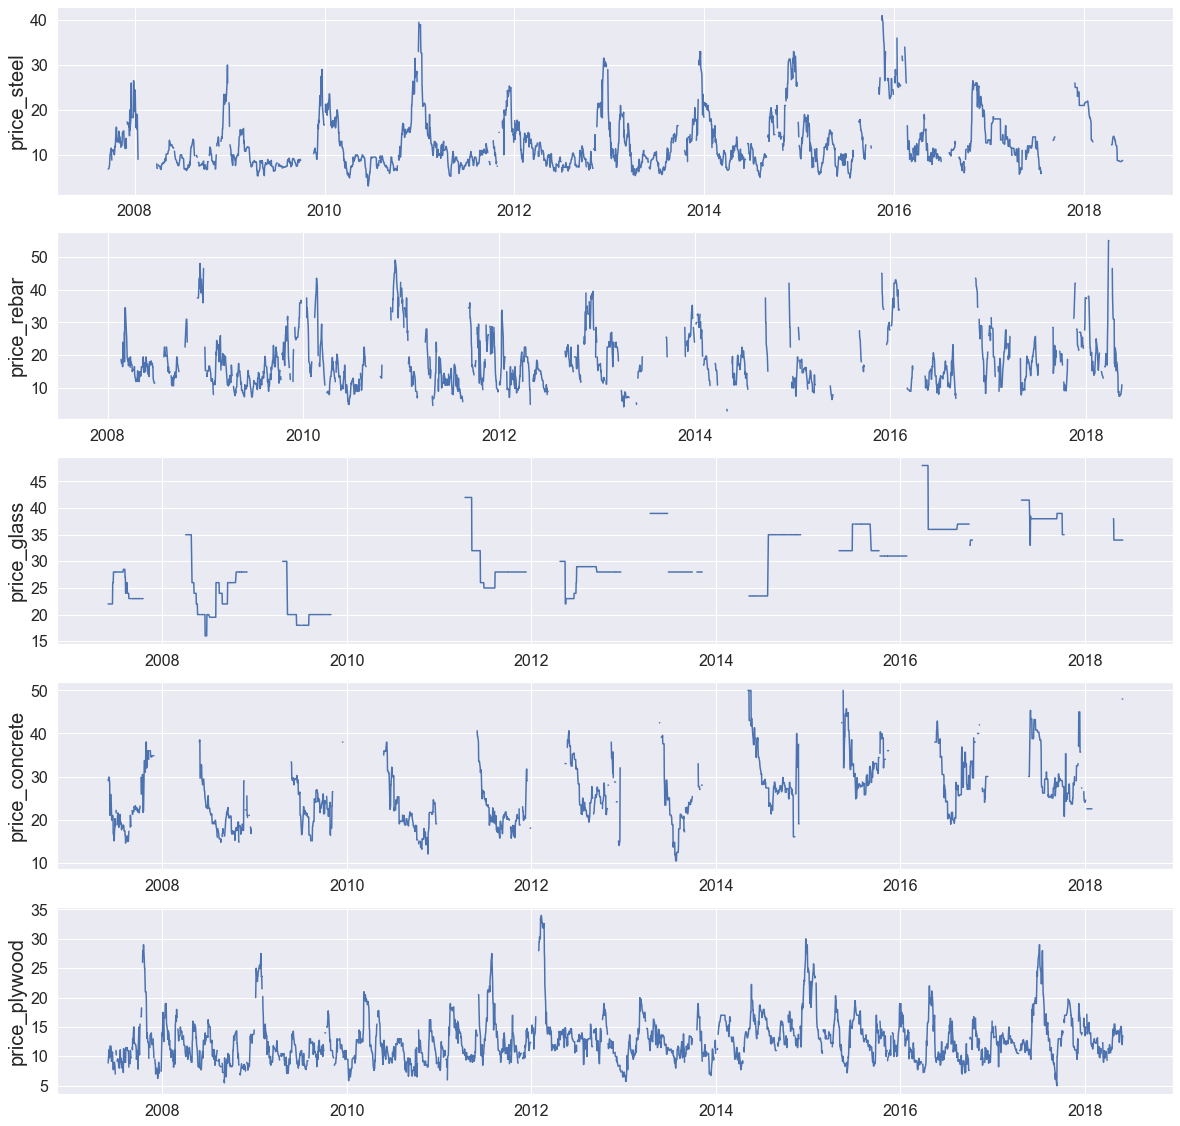

In [8]:
df_plot(df, features)

We can see that there is some seasonality in the price of steel, rebar and concrete. and we have a lot of missing data. 

In [9]:
# Seasonal Plot of a Time Series
df['year'] = [d.year for d in df.index]
df['month'] = [d.month for d in df.index]
df['year_month'] = [dt.strptime(d.strftime("%Y-%m"), "%Y-%m")  for d in df.index]
#df['week'] = [int(d.strftime("%U")) for d in df.index]
years = df['year'].unique()

In [10]:
df.sample(5)

,price_steel,price_rebar,price_glass,price_concrete,price_plywood,year,month,year_month
date,,,,,,,,
2014-09-30,14.500000,17.833333,35.0,28.0,12.00,2014,9,2014-09-01
2014-06-16,NaN,17.333333,23.5,39.0,13.75,2014,6,2014-06-01
2014-11-28,31.333333,NaN,35.0,NaN,NaN,2014,11,2014-11-01
2015-11-06,23.500000,NaN,31.0,NaN,10.00,2015,11,2015-11-01
2018-01-24,18.500000,17.800000,NaN,22.5,14.00,2018,1,2018-01-01


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2945 entries, 2007-01-01 to 2018-06-19
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   price_steel     2309 non-null   float64       
 1   price_rebar     1649 non-null   float64       
 2   price_glass     1472 non-null   float64       
 3   price_concrete  1447 non-null   float64       
 4   price_plywood   2673 non-null   float64       
 5   year            2945 non-null   int64         
 6   month           2945 non-null   int64         
 7   year_month      2945 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 207.1 KB


In [12]:
#Group data by year and month
df_month = df.groupby(['year_month']).mean()
df_month

,price_steel,price_rebar,price_glass,price_concrete,price_plywood,year,month
year_month,,,,,,,
2007-01-01,NaN,NaN,NaN,NaN,NaN,2007,1
2007-02-01,NaN,NaN,NaN,NaN,NaN,2007,2
2007-03-01,NaN,NaN,NaN,NaN,NaN,2007,3
2007-04-01,NaN,NaN,NaN,NaN,NaN,2007,4
2007-05-01,NaN,NaN,NaN,NaN,NaN,2007,5
...,...,...,...,...,...,...,...
2018-02-01,13.125000,18.896111,NaN,NaN,11.908333,2018,2
2018-03-01,NaN,22.593750,NaN,NaN,10.384398,2018,3
2018-04-01,13.375000,24.187500,35.6,NaN,12.205833,2018,4


In [13]:
# Drop rows with all columns missing
df_month.drop(df_month[df_month.loc[:,'price_steel':'price_plywood'].isna().all(axis=1)].index, inplace=True)

In [14]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2007-06-01 to 2018-05-01
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_steel     125 non-null    float64
 1   price_rebar     113 non-null    float64
 2   price_glass     81 non-null     float64
 3   price_concrete  84 non-null     float64
 4   price_plywood   132 non-null    float64
 5   year            132 non-null    int64  
 6   month           132 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 8.2 KB


In [15]:
def df_plot_compare(df1, df2, features):
    i = 1
    nrows=len(features)
    plt.figure(figsize = (20,20))
    for col in features:
        plt.subplot(nrows, 1, i)
        plt.plot(df1[col], label='Monthly')
        plt.plot(df2[col], label='Daily')
        plt.ylabel(col,fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        i += 1
        plt.legend()
    plt.show()

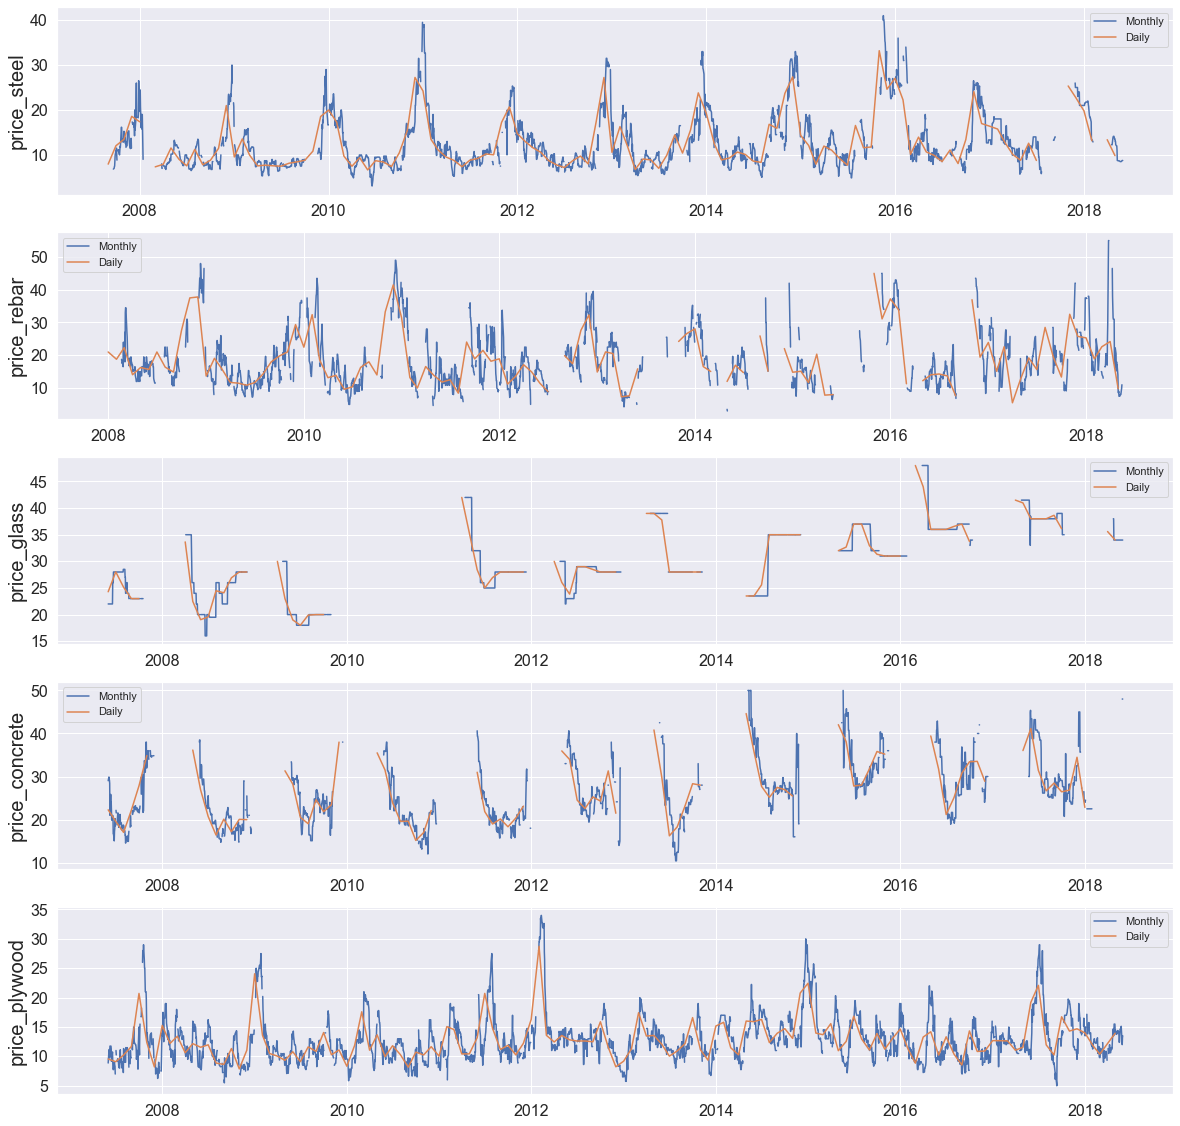

In [16]:
df_plot_compare(df, df_month, features)

In [17]:
# Dealing with missing data: Backward Fill 
df_month_bfill = df_month.bfill()

In [18]:
df_month_bfill.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2007-06-01 to 2018-05-01
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_steel     132 non-null    float64
 1   price_rebar     132 non-null    float64
 2   price_glass     132 non-null    float64
 3   price_concrete  132 non-null    float64
 4   price_plywood   132 non-null    float64
 5   year            132 non-null    int64  
 6   month           132 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 8.2 KB


In [19]:
# Box plots show changes over year or month
def draw_box(df, col):
    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20,7))
    sns.boxplot(x='year', y=col, data=df, ax=axes[0])
    sns.boxplot(x='month', y=col, data=df, ax=axes[1])
    #sns.boxplot(x='week', y=col, data=df, ax=axes[2])

    # Set Title
    axes[0].set_title('Changes over Years', fontsize=18) 
    axes[1].set_title('Changes over Months', fontsize=18)
    #axes[2].set_title('Changes over Weeks', fontsize=18)
    plt.show()

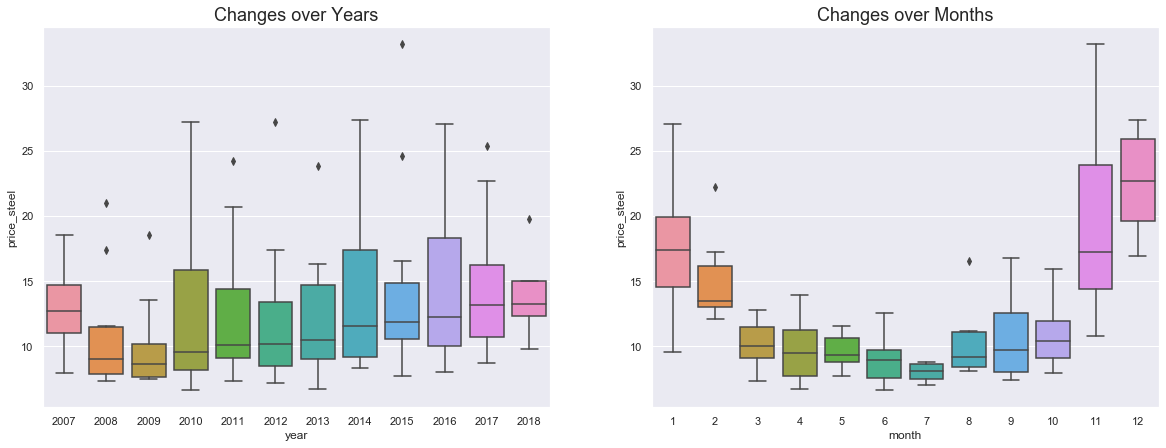

In [20]:
draw_box(df_month, 'price_steel')

We can see that the overall price of steel increases slowly with year, but changes a lot during a year. It had lower prices in summer, and reached the lowest in July.

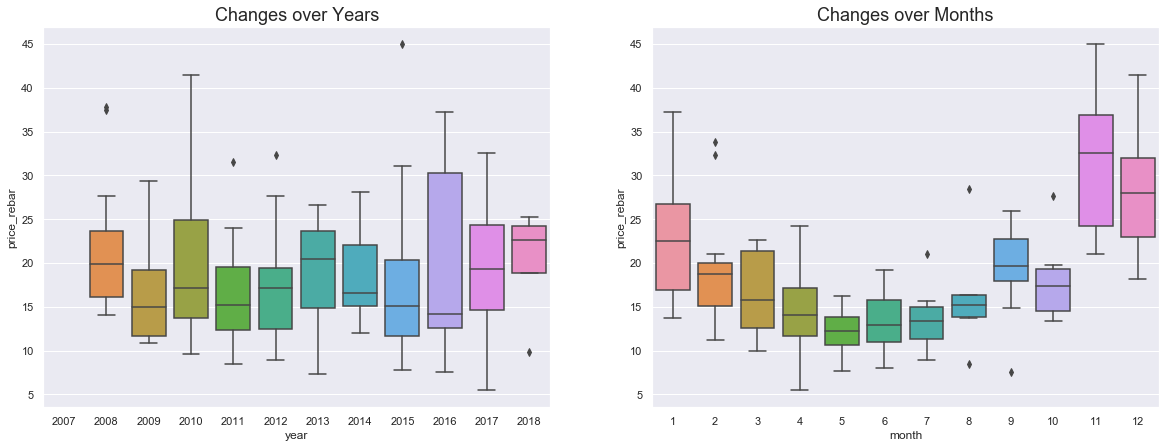

In [21]:
draw_box(df_month, 'price_rebar')

We can see that the overall price of rebar fluctuates with year, but has a more clear trend during a year. It also had lower prices in summer, and reached the lowest in May.

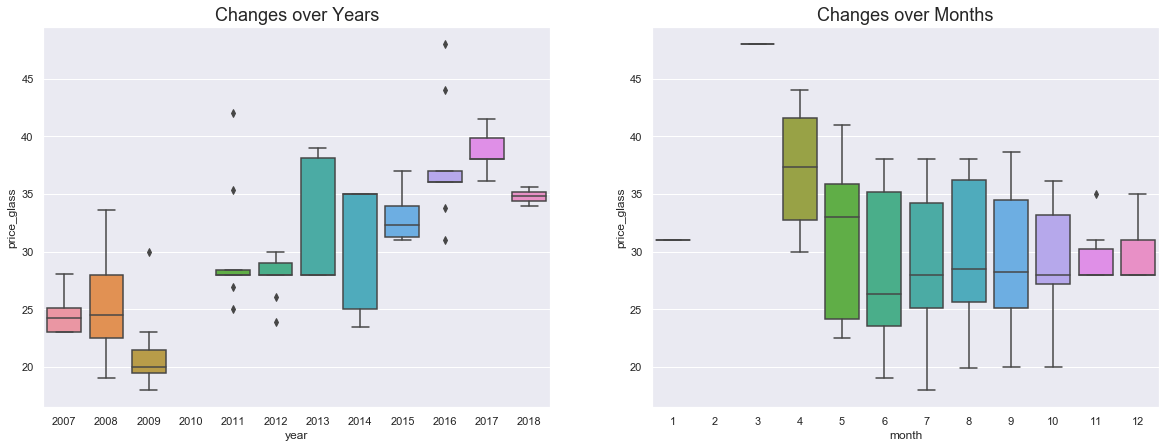

In [22]:
draw_box(df_month, 'price_glass')

For glass, we have a high ratio of missing data. So the trend is not so clear and trustful. From the limited available data, we can see that the price of glass seems increasing over year, and during our interested period from June to Nov, the price of glass won't chage a lot.

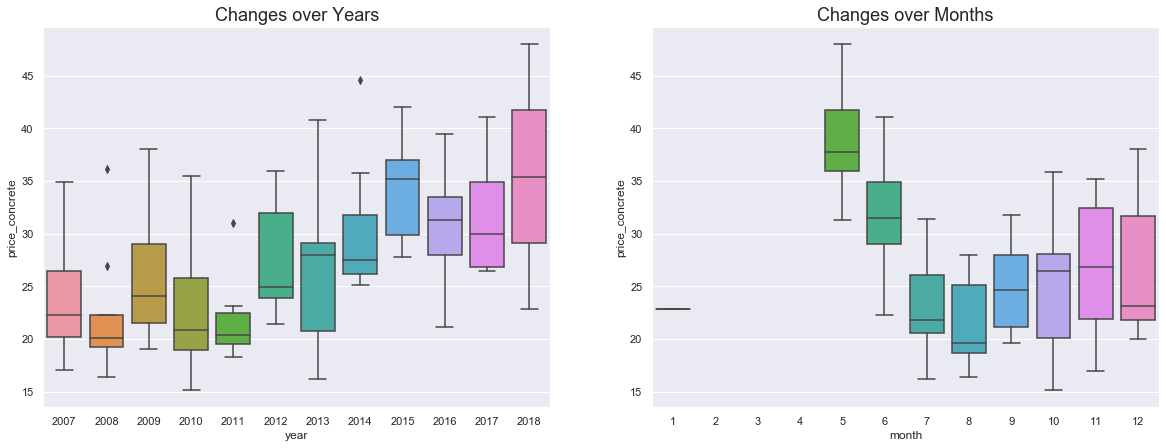

In [23]:
draw_box(df_month, 'price_concrete')

For concrete, the price increases over year with fluctuation. In each year, it has the lowest price in August.

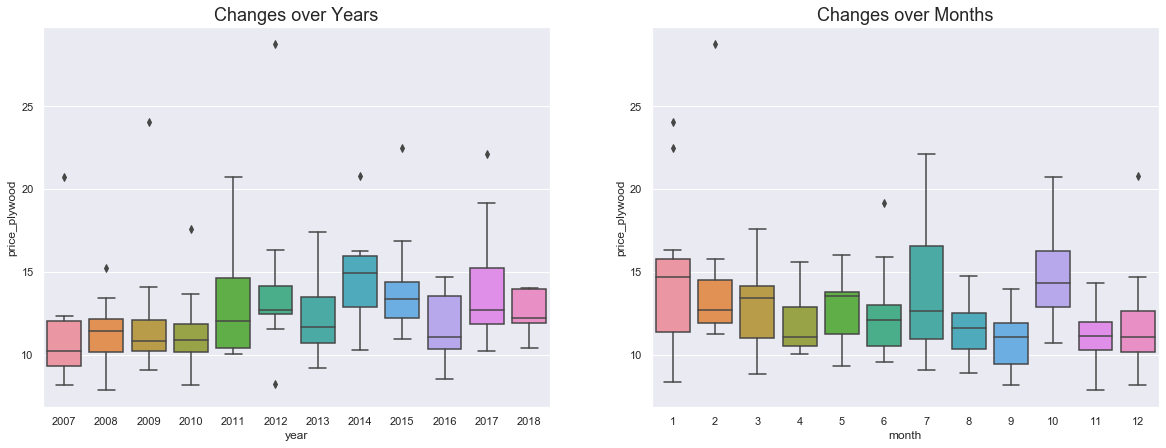

In [24]:
draw_box(df_month, 'price_plywood')

For plywood, the price also increases over year with fluctuation. It did't show clear trend during a year, but may have the lowest price in Sep.

# 3. Decomposition

In [25]:
def decompose(df,col):
    # Additive Decomposition
    result_add = seasonal_decompose(df[col], model='additive', extrapolate_trend='freq')
    # Plot
    plt.rcParams.update({'figure.figsize': (10,8)})
    result_add.plot()    
    plt.show()

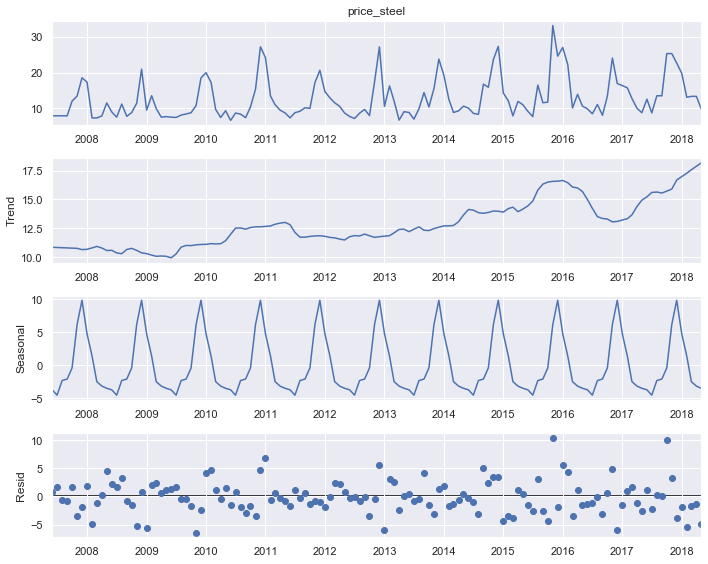

In [26]:
decompose(df_month_bfill, 'price_steel')

We can see that the overall price of steel increases slowly with year. It has a clear seasonality cycle of 12 months, reaches the lowest in July, and reaches the highest in Dec.

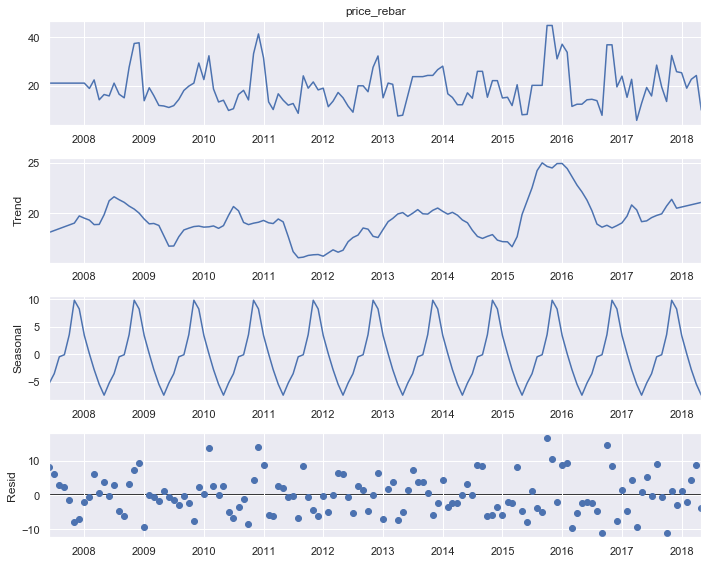

In [27]:
decompose(df_month_bfill, 'price_rebar')

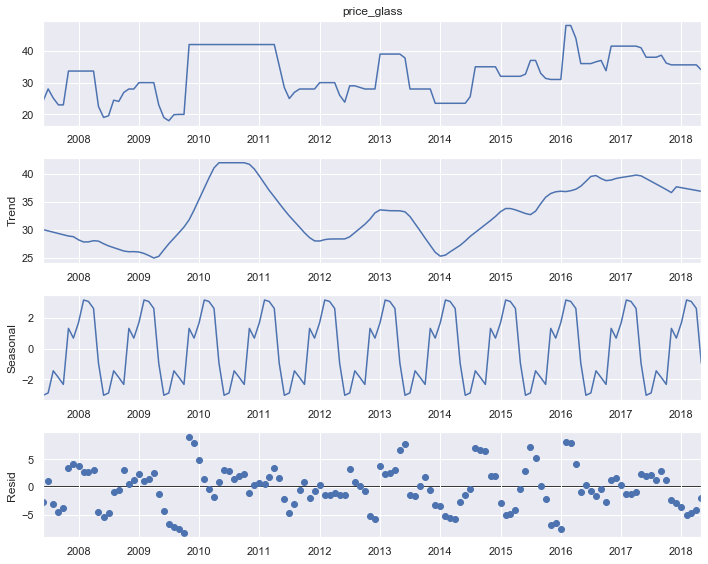

In [28]:
decompose(df_month_bfill, 'price_glass')

For glass, the trend fluctuates with year. The seasonal coponents have a very small magnitude compared to the trend an residues, and thus can be ignored.

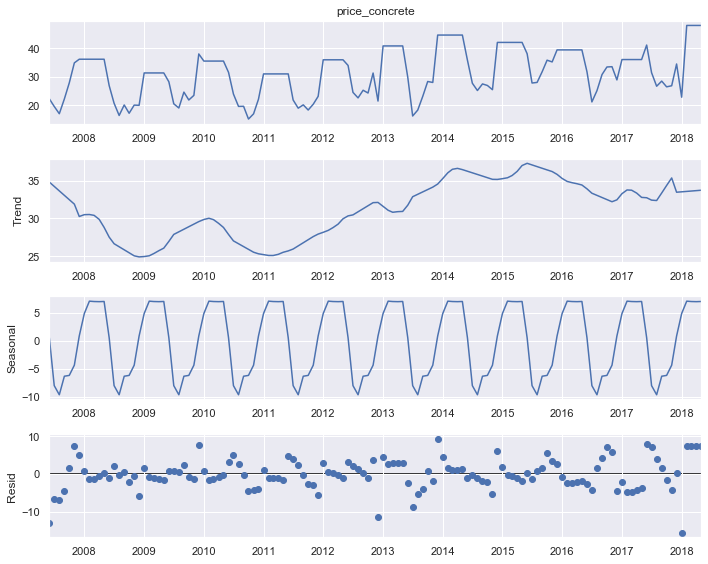

In [29]:
decompose(df_month_bfill, 'price_concrete')

For concrete, the price fluctuates over years, and shows a seasonality of 12 months. In each year, it has the lowest price in August.

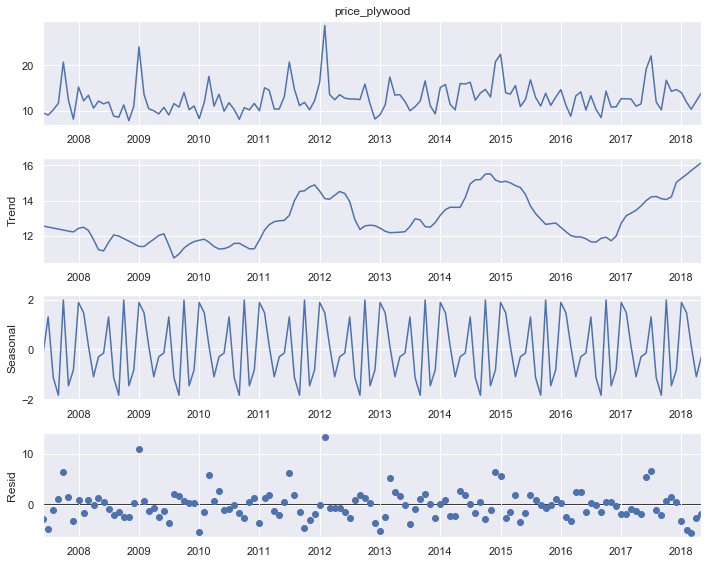

In [30]:
decompose(df_month_bfill, 'price_plywood')

For plywood, the price fluctuates over year. Its seasonal coponents have a very small magnitude compared to the trend and residues, and can be ignored.

In [31]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
#df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
#df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
#df_reconstructed.head()

# 4. Autocorrelations and Partial Autocorrelations

In [32]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
#fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
#plot_acf(df.value.tolist(), lags=50, ax=axes[0])
#plot_pacf(df.value.tolist(), lags=50, ax=axes[1])

In [33]:
def auto_plot(df, col, n_lag):
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    plot_acf(df[col], lags=n_lag, ax=axes[0])
    plot_pacf(df[col], lags=n_lag, ax=axes[1])
    fig.suptitle('Correlation Plots of '+ col, y=1.05) 
    plt.show()

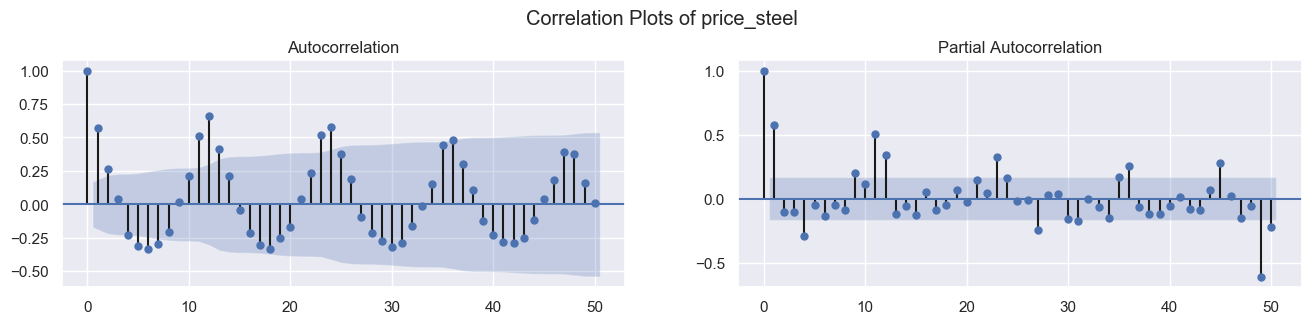

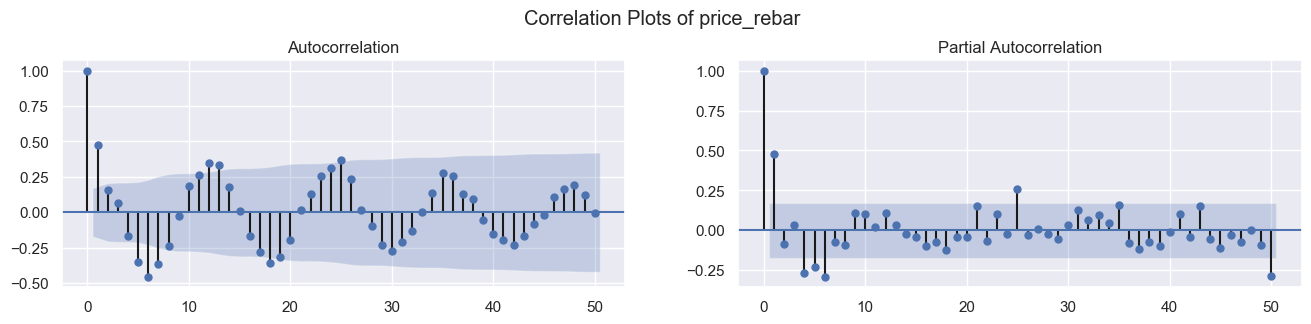

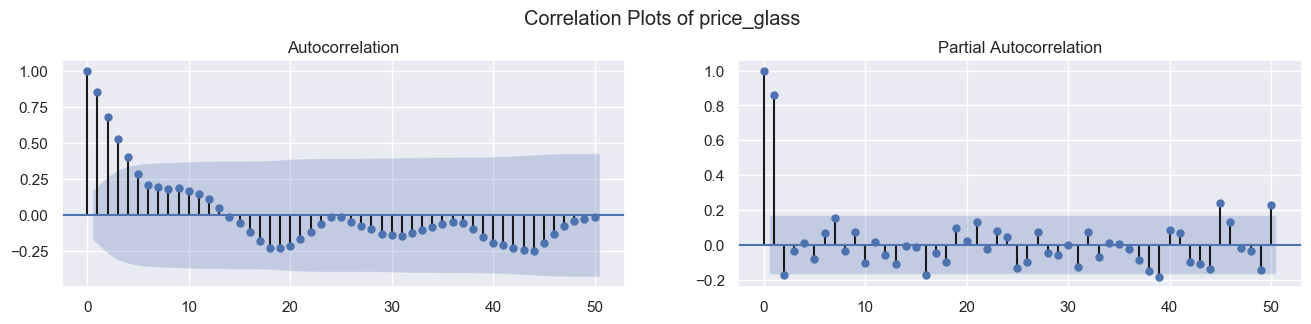

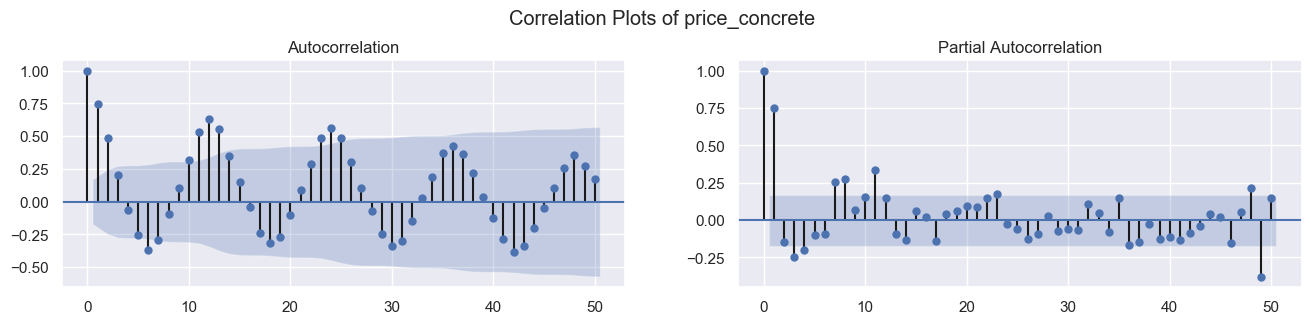

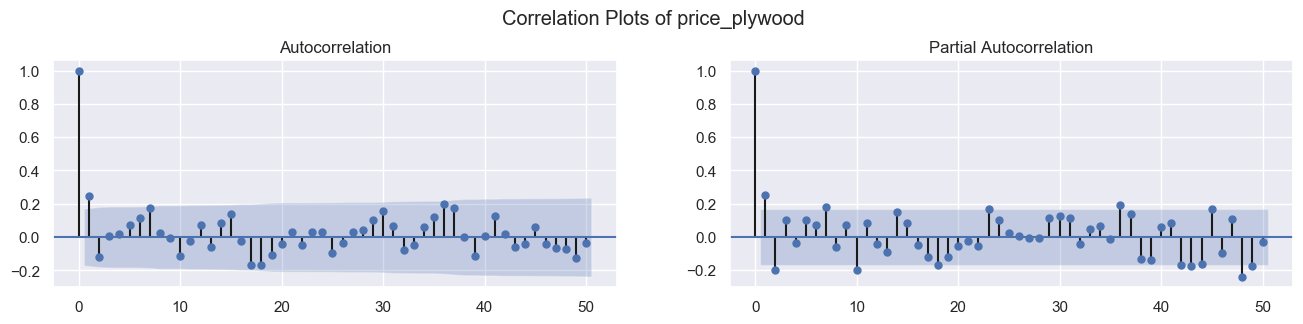

In [34]:
for col in features:
    auto_plot(df_month_bfill,col,50)

# 5. SARIMA Forecast

In [37]:
#!pip install pyramid-arima
#!pip install pmdarima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [151]:
# Seasonal - fit stepwise auto-ARIMA
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html
    
def sarima(train, feature_col, 
           start_p=1, d=None, start_q=1, max_p=3, max_q=3, 
           m=12, start_P=0, seasonal=True, D=1, trace=False, summary=True):
    data = train[feature_col]
    smodel = pm.auto_arima(data, 
                            start_p=start_p, # start value of p, not the min value of p
                            start_q=start_q, # start value of q, not the min value of q
                            test='adf', # use adftest to find optimal 'd'
                            max_p=max_p, max_q=max_q, # maximum p and q
                            m=m, # frequency of series
                            start_P=start_P, # start value of P
                            seasonal=seasonal,
                            d=d, # if d=None, let model determine 'd'
                            D=D, 
                            trace=trace,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
                             #out_of_sample_size=12)
    if summary: print(smodel.summary())
    return smodel

In [215]:
# Forecast
def forecast(train, feature_col, smodel, n_periods, test=None):
    data = train[feature_col]
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(data.index[-1], periods = n_periods+1, freq='MS')
    
    # make series for plotting purpose
    fitted_series = pd.Series([data.iloc[-1]]+fitted.tolist(), index=index_of_fc)
    lower_series = pd.Series([data.iloc[-1]]+confint[:, 0].tolist(), index=index_of_fc)
    upper_series = pd.Series([data.iloc[-1]]+confint[:, 1].tolist(), index=index_of_fc)

    # Plot
    plt.figure(figsize=(10,3))
    plt.plot(data, label='Train Data')
    if test is not None:
        plt.plot(pd.concat([data[-1:], test[feature_col]]), label='Test Data', color='darkgreen')
        
    pred = smodel.predict_in_sample(star=0, dynamic=False) 
    #The dynamic keyword affects in-sample prediction. If dynamic is False, 
    # then the in-sample lagged values are used for prediction. If dynamic is True, 
    #then in-sample forecasts are used in place of lagged dependent variables. 
    plt.plot(train.index, pred, label='In sample pridiction', color='orange')
    
    plt.plot(fitted_series, label='Forcasting', color='red')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)
    
    plt.legend()
    plt.title("SARIMA Forecasting for "+str(feature_col))
    plt.show()
    return fitted_series[1:len(test)+1] if test is not None else None

In [207]:
data = df_month_bfill
split = 12
train, test = data[:-split], data[-split:]

# Train the model based on the training data, and evaluate the model on the testing data
def train_test(train, test, feature_col, start_p=1, d=None, start_q=1, max_p=3, max_q=3, 
           m=12, start_P=0, seasonal=True, D=1, trace=False, summary=True):
    smodel = sarima(train, feature_col, start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_q=max_q, 
           m=m, start_P=start_P, seasonal=seasonal, D=D, trace=trace, summary=summary)
    print(smodel)
    n_periods = len(test)
    preds = forecast(train, feature_col, smodel, n_periods, test)
    # Print the error:
    print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test[feature_col], preds)))
    # The residual plots in ARIMA model
    smodel.plot_diagnostics(figsize=(10,10))
    plt.show()
    
    
# Forcasting next 6 months based on the model trained on all data
def forecasting(data, feature_col, start_p=1, d=None, start_q=1, max_p=3, max_q=3, 
           m=12, start_P=0, seasonal=True, D=1, trace=False, summary=True):
    smodel = sarima(data,feature_col, start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_q=max_q, 
           m=m, start_P=start_P, seasonal=seasonal, D=D, trace=trace, summary=summary)
    n_periods = 6
    preds = forecast(data, feature_col, smodel, n_periods)

In [88]:
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
for col in features:
    p_val, should_diff = adf_test.should_diff(data[col])  
    print(col, p_val,should_diff)

price_steel 0.01 False
price_rebar 0.01 False
price_glass 0.06417429051671562 True
price_concrete 0.01 False
price_plywood 0.01 False


In [89]:
# Pmdarima also provides a more handy interface for estimating 
# your d parameter more directly. This is the preferred public 
# method for accessing tests of stationarity:
from pmdarima.arima.utils import ndiffs

for col in features:
    # Estimate the number of differences using an ADF test:
    n_adf = ndiffs(data[col], test='adf')  

    # Or a KPSS test (auto_arima default):
    n_kpss = ndiffs(data[col], test='kpss')  

    # Or a PP test:
    n_pp = ndiffs(data[col], test='pp')  
    print(col, n_adf,n_kpss,n_pp)

price_steel 0 1 0
price_rebar 0 0 0
price_glass 1 1 0
price_concrete 0 1 0
price_plywood 0 0 0


                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  120
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -289.116
Date:                    Fri, 03 Apr 2020   AIC                            584.231
Time:                            17:07:42   BIC                            592.278
Sample:                                 0   HQIC                           587.494
                                    - 120                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4644      0.138      3.353      0.001       0.193       0.736
ma.S.L12      -0.7201      0.084     -8.551      0.000      -0.885      -0.555
sigma2        11.416

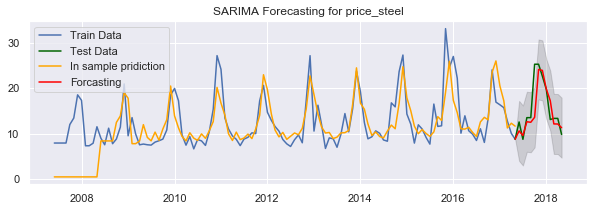

Test RMSE: 3.756


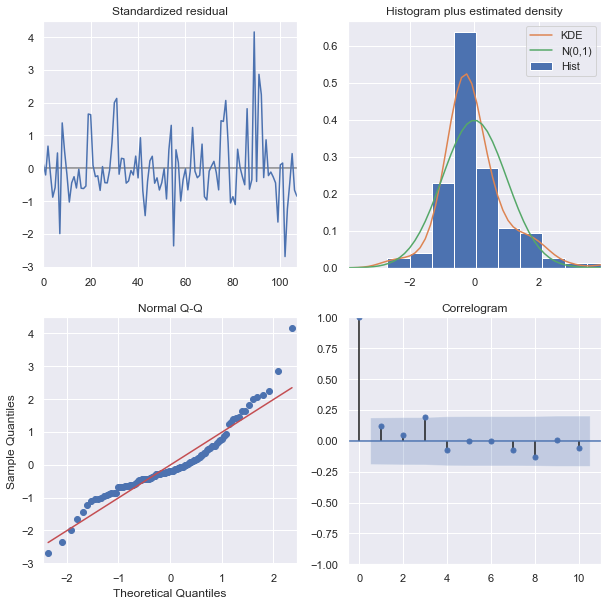

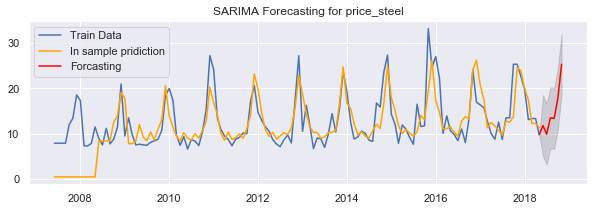

In [216]:
feature_col = 'price_steel'
train_test(train, test, feature_col, start_p=1, start_q=1, max_p=2, max_q=3, 
           m=12, start_P=0, seasonal=True, D=1)#, trace=True)
forecasting(data, feature_col, start_p=1, start_q=1, max_p=2, max_q=3, 
           m=12, start_P=0, seasonal=True, D=1, summary=False)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -363.765
Date:                            Fri, 03 Apr 2020   AIC                            735.530
Time:                                    17:08:14   BIC                            746.258
Sample:                                         0   HQIC                           739.880
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1074      0.288      0.373      0.709      -0.457       0.672
ma.L1          0.3297      0.091   

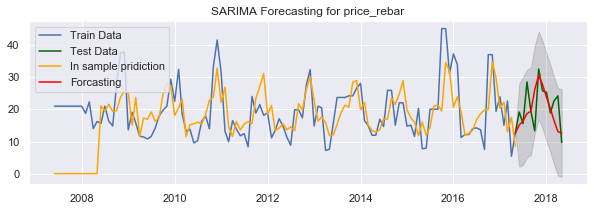

Test RMSE: 6.154


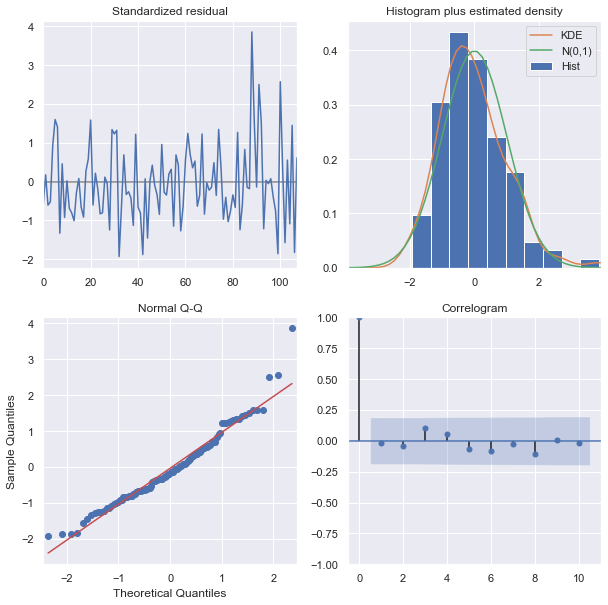

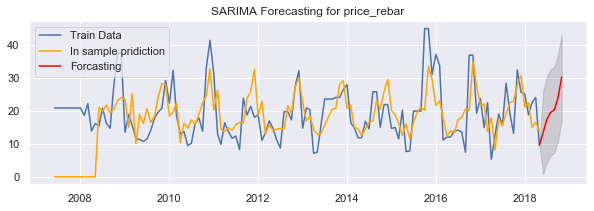

In [217]:
feature_col = 'price_rebar'
train_test(train, test, feature_col, start_p=2, start_q=2, max_p=2, max_q=2, 
           m=12, start_P=0, seasonal=True, D=1)#, trace=True)
forecasting(data, feature_col, start_p=2, start_q=2, max_p=2, max_q=2, 
           m=12, start_P=0, seasonal=True, D=1, summary=False)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -329.031
Date:                Fri, 03 Apr 2020   AIC                            666.062
Time:                        17:08:30   BIC                            677.212
Sample:                             0   HQIC                           670.590
                                - 120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5980      2.125      2.634      0.008       1.433       9.763
ar.L1          1.0080      0.156      6.479      0.000       0.703       1.313
ar.L2         -0.1809      0.144     -1.259      0.2

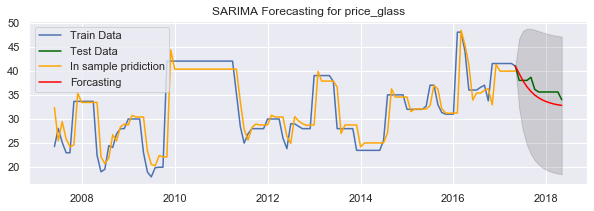

Test RMSE: 1.870


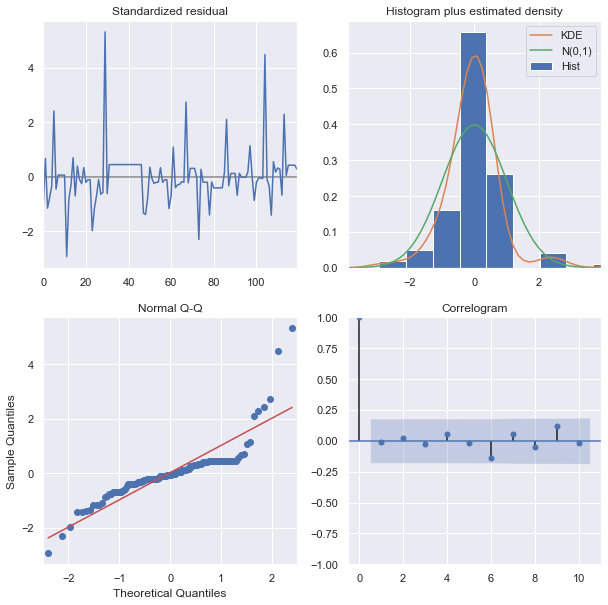

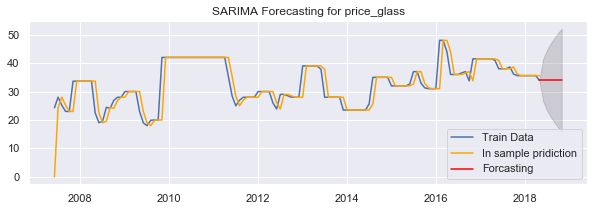

In [218]:
feature_col = 'price_glass'
train_test(train, test, feature_col, start_p=1, start_q=1, max_p=2, max_q=5, 
           seasonal=False)#, trace=True)
forecasting(data, feature_col, start_p=1, start_q=1, max_p=2, max_q=5, 
            seasonal=False, summary=False)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -303.045
Date:                            Fri, 03 Apr 2020   AIC                            618.089
Time:                                    17:08:44   BIC                            634.126
Sample:                                         0   HQIC                           624.590
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0021      0.013     -0.164      0.870      -0.028       0.024
ar.L1          0.5113      0.120   

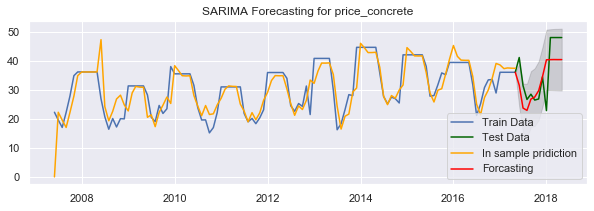

Test RMSE: 7.716


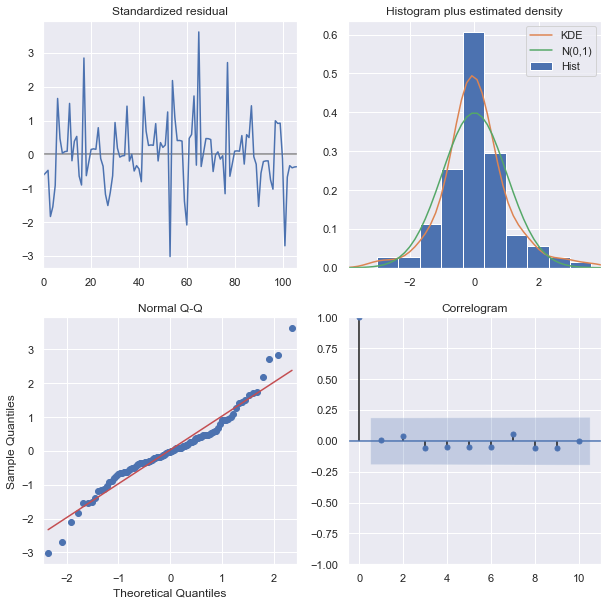

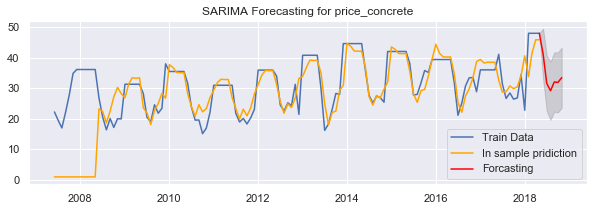

In [219]:
feature_col = 'price_concrete'
train_test(train, test, feature_col, start_p=1, start_q=1, max_p=2, max_q=3, 
           m=12, start_P=0, seasonal=True, D=1)#, trace=True)
forecasting(data, feature_col, start_p=1, start_q=1, max_p=2, max_q=3, 
           m=12, start_P=0, seasonal=True, D=1, summary=False)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -283.034
Date:                            Fri, 03 Apr 2020   AIC                            574.068
Time:                                    17:09:09   BIC                            584.797
Sample:                                         0   HQIC                           578.418
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1447      0.162      0.896      0.370      -0.172       0.461
ma.L1          0.3615      0.081   

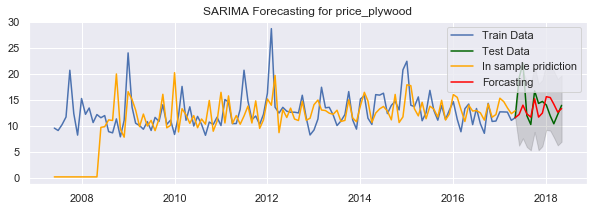

Test RMSE: 3.666


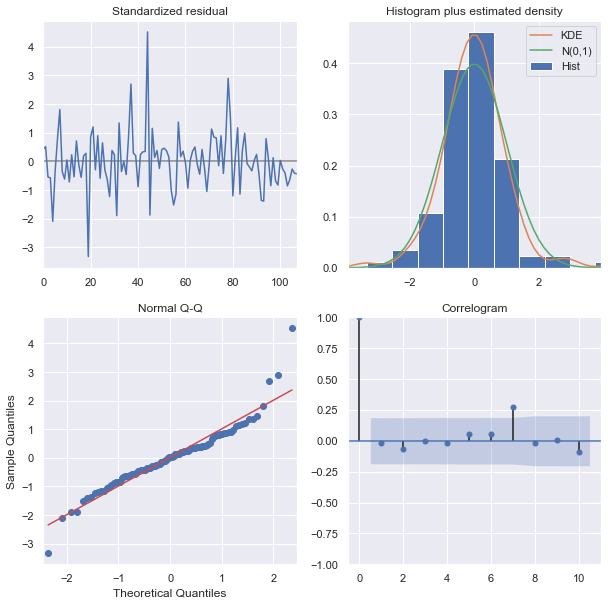

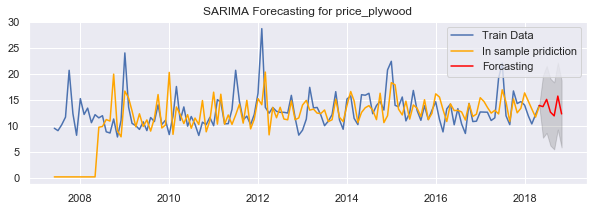

In [220]:
feature_col = 'price_plywood'
train_test(train, test, feature_col, start_p=1, start_q=1, max_p=2, max_q=2, 
           m=12, start_P=0, seasonal=True, D=1)#, trace=True)
forecasting(data, feature_col, start_p=1, start_q=1, max_p=2, max_q=2, 
           m=12, start_P=0, seasonal=True, D=1, summary=False)

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  120
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 3)   Log Likelihood                -300.915
Date:                           Fri, 03 Apr 2020   AIC                            611.830
Time:                                   17:13:41   BIC                            625.641
Sample:                                        0   HQIC                           617.437
                                           - 120                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0598      0.072      0.837      0.403      -0.080       0.200
ar.L1         -0.5473      0.171     -3.196

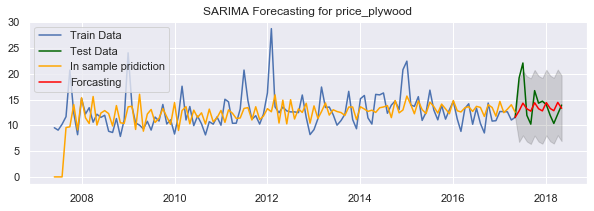

Test RMSE: 3.328


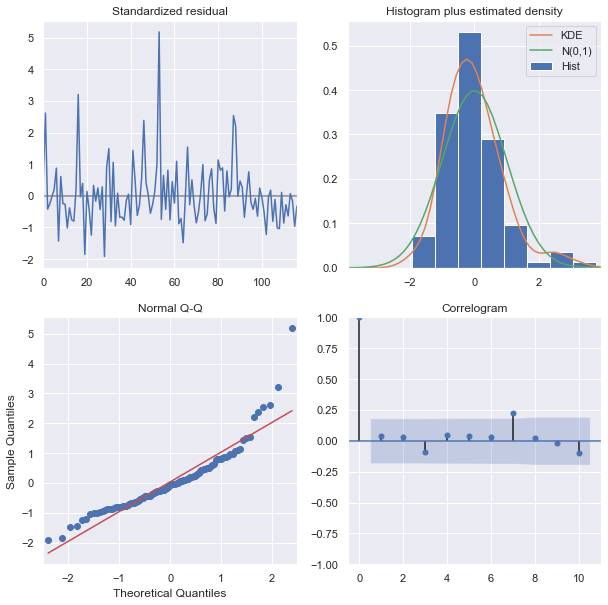

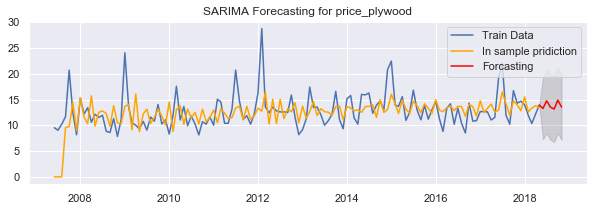

In [223]:
feature_col = 'price_plywood'
train_test(train, test, feature_col, start_p=1, start_q=1, max_p=2, max_q=2, 
           m=3, start_P=0, seasonal=True, D=1)#, trace=True)
forecasting(data, feature_col, start_p=1, start_q=1, max_p=2, max_q=2, 
           m=3, start_P=0, seasonal=True, D=1, summary=False)